# single-cell reference map of transcriptional states for human blood and tissue T cell activation

https://data.humancellatlas.org/explore/projects/4a95101c-9ffc-4f30-a809-f04518a23803/expression-matrices


paper link: https://www.nature.com/articles/s41467-019-12464-3

Human T cells coordinate adaptive immunity in diverse anatomic compartments through production of cytokines and effector molecules, but it is unclear how tissue site influences T cell persistence and function. Here, we use single cell RNA-sequencing (scRNA-seq) to define the heterogeneity of human T cells isolated from lungs, lymph nodes, bone marrow and blood, and their functional responses following stimulation. Through analysis of >50,000 resting and activated T cells, we reveal tissue T cell signatures in mucosal and lymphoid sites, and lineage-specific activation states across all sites including distinct effector states for CD8+ T cells and an interferon-response state for CD4+ T cells. Comparing scRNA-seq profiles of tumor-associated T cells to our dataset reveals predominant activated CD8+ compared to CD4+ T cell states within multiple tumor types. Our results therefore establish a high dimensional reference map of human T cell activation in health for analyzing T cells in disease.

In [ ]:
#https://data.humancellatlas.org/explore/projects/4a95101c-9ffc-4f30-a809-f04518a23803/expression-matrices
#!wget https://data.humancellatlas.org/project-assets/project-matrices/4a95101c-9ffc-4f30-a809-f04518a23803.homo_sapiens.mtx.zip -O data/huBL_tissue-tcell.zip

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
print(ad.__version__)

/home/philip/miniconda3/envs/scanpy38/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


0.7.1


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0


In [3]:
results_file = './write/huBL_tissue_tcell.h5ad'  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_mtx(
    './data/huBL_tissue-tcell/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)  

... reading from cache file cache/data-huBL_tissue-tcell-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.obs_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 267360 × 58347 
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


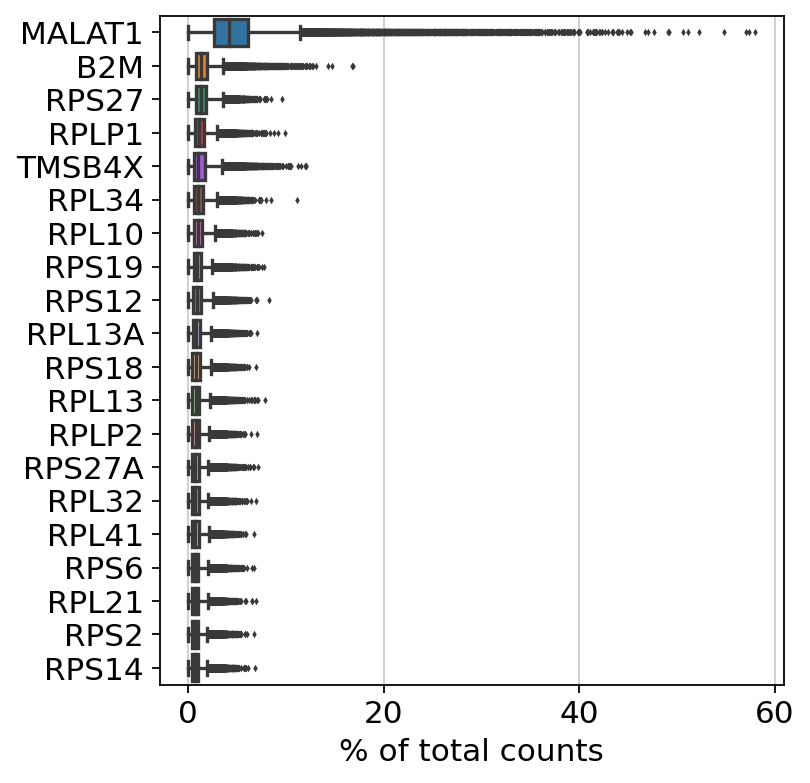

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 126678 cells that have less than 200 genes expressed
filtered out 22351 genes that are detected in less than 3 cells


In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

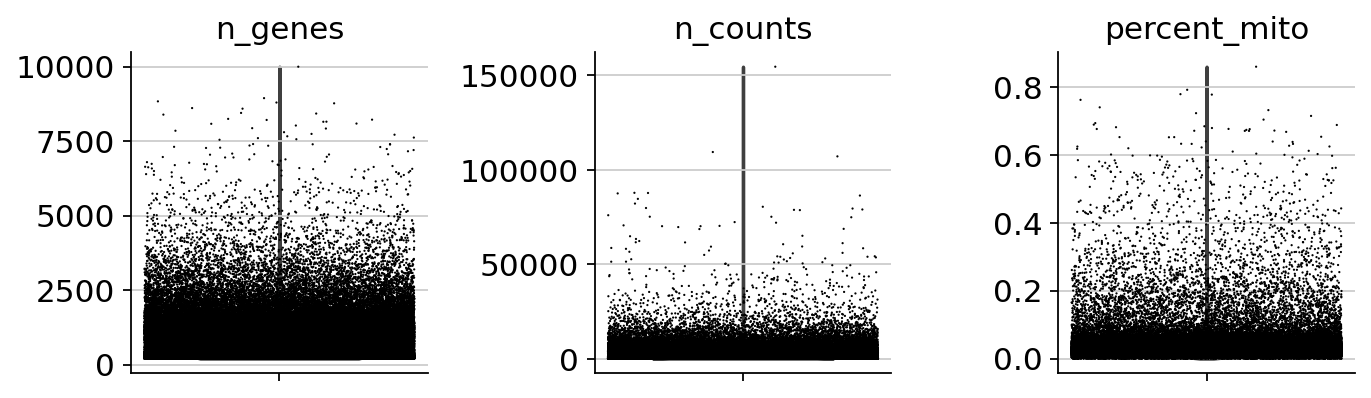

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.6, multi_panel=True)

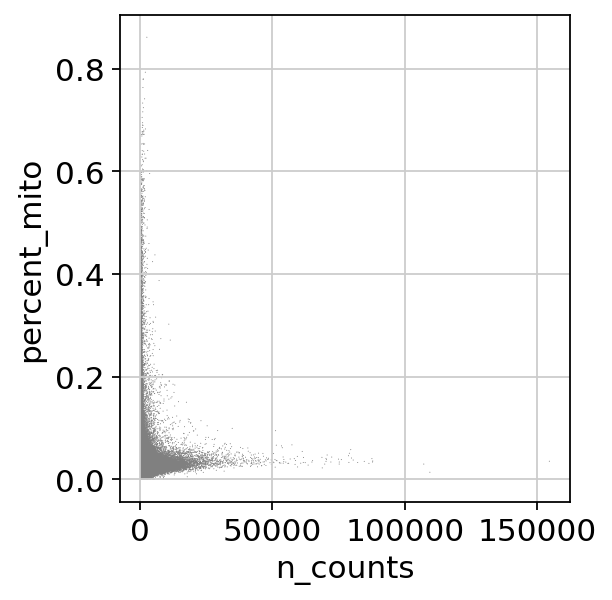

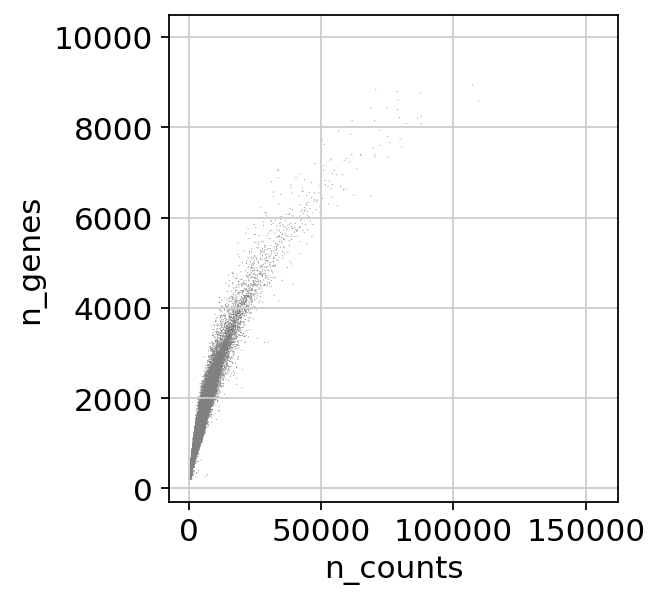

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata

AnnData object with n_obs × n_vars = 140682 × 35996 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [13]:

adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.2, :]

In [14]:

sc.pp.normalize_total(adata, target_sum=5e4)

normalizing counts per cell


ValueError: could not convert integer scalar

In [ ]:
sc.pp.log1p(adata)